In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e1f8ac0b-299c-269a-3153-87d3cfc8627b)


## Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
def get_lines(file):

  with open(file, 'r') as f:
    return f.readlines()

In [ ]:
get_lines(filenames[0])[:5]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n']

In [ ]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 444 ms, sys: 146 ms, total: 590 ms
Wall time: 626 ms


In [ ]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
test_samples[:4]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8},
 {'line_number': 1,
  'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'total_lines': 8},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'total_lines': 8},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspart

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

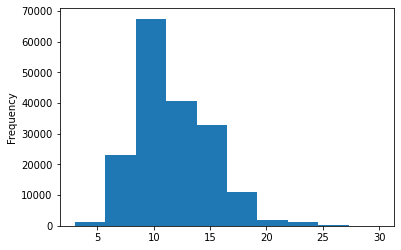

In [ ]:
train_df['total_lines'].plot.hist()

### Get list of sentences

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numerics label

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating models


In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Model 0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(test_sentences, test_labels_encoded), model_0.score(val_sentences, val_labels_encoded)

(0.716674962667994, 0.7218323844829869)

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-25 14:56:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-25 14:56:32 (61.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Prepare data for deeper models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

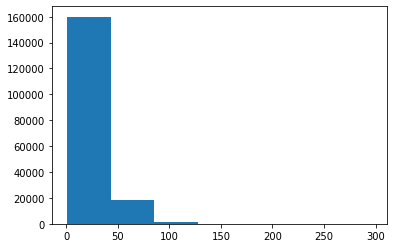

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=7);

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

### Text Vectorizer

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)
text_vectorizer.adapt(train_sentences)

In [ ]:
import random

target = random.choice(train_sentences)
print('\nText: ', target)
print('\nLength: ', len(target.split()))
print('\nText Vectorized: ', text_vectorizer([target]))


Text:  the acupoint catgut embedding therapy combined with acupuncture-moxibustion therapy are safe and effective in the treatment of allergic rhinitis and display the more roles in the long-term efficacy .

Length:  29

Text Vectorized:  tf.Tensor(
[[   2 2434 5774 8938   66  286    7 8529   66   58  514    3  137    5
     2   19    4 1892 2640    3 4904    2   69 5705    5    2  335   79
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [ ]:
rct_20k_vocab = text_vectorizer.get_vocabulary()
print('Numbers of words in vocab:', len(rct_20k_vocab))
print('Most common words:', rct_20k_vocab[:5])
print('Least common words:', rct_20k_vocab[-5:])

Numbers of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Text embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

print('Sentence before vectorization: ', target)
print('\nSentence after vectorization: ', text_vectorizer([target]))
print('\nSentence after embedding: ', token_embed(text_vectorizer([target])))
print('\nShape embedding sentence: ', token_embed(text_vectorizer([target])).shape)

Sentence before vectorization:  the acupoint catgut embedding therapy combined with acupuncture-moxibustion therapy are safe and effective in the treatment of allergic rhinitis and display the more roles in the long-term efficacy .

Sentence after vectorization:  tf.Tensor(
[[   2 2434 5774 8938   66  286    7 8529   66   58  514    3  137    5
     2   19    4 1892 2640    3 4904    2   69 5705    5    2  335   79
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)

Sentence after embedding:  tf.Tensor(
[[[-0.01218776 -0.00106957 -0.01530497 ... -0.01478402  0.01529384
    0.01121485]
  [ 0.02066093  0.01256381  0.01595763 ...  0.02474016  0.00632628
   -0.04984793]
  [-0.04685366 -0.01184685 -0.02263602 ... -0.00459749  0.04796512
   -0.01421075]
  ...
  [-0.00483278 -0.00663254 -0.03332954 ... -0.00378459 -0.04556862
    0.02907243]
  [-0.00483278 -0.00663254 -0.0333

### Create datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_7 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_7   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_17 (Dense)            (None, 5)                 325

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 12ms/step - loss: 0.9294 - accuracy: 0.6313 - val_loss: 0.6922 - val_accuracy: 0.7350
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6620 - accuracy: 0.7537 - val_loss: 0.6330 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6207 - accuracy: 0.7733 - val_loss: 0.5987 - val_accuracy: 0.7829


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6003 - accuracy: 0.7844


[0.6003310680389404, 0.7844234108924866]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.44234079173839,
 'f1': 0.7816959085656122,
 'precision': 0.7808109911359409,
 'recall': 0.7844234079173839}

### Model 2: feature extraction with pre trained token embedding

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
target = random.choice(train_sentences)
print('Sentence: ', target)
embedded_target = tf_hub_embedding_layer([target])
print('Sequence after embedding: ', embedded_target)
print('Shape of sequence embedded: ', embedded_target.shape)

Sentence:  this study aimed to determine the effect of topical lidocaine on penetration-aspiration scale ( pas ) scores and patient comfort and tolerance of flexible endoscopic evaluation of swallowing ( fees ) examinations in dysphagic patients .
Sequence after embedding:  tf.Tensor(
[[ 7.71151436e-03  6.10309001e-03 -3.55999582e-02 -3.37663814e-02
   7.94827472e-04  1.28713148e-02  1.66932885e-02 -1.10720741e-02
   2.69304421e-02  8.78430624e-03  7.53203407e-02  4.83757406e-02
   6.14561699e-02  3.88935916e-02 -4.75131944e-02 -7.16535840e-03
  -8.24751928e-02  4.81768139e-02 -3.02433167e-02 -6.47321045e-02
   6.17498234e-02  4.57970910e-02 -6.76450357e-02 -4.67739925e-02
  -9.03872959e-03 -1.30225420e-02 -3.57451513e-02 -5.19342571e-02
   3.55519317e-02 -1.47365937e-02 -3.07610780e-02  8.12680647e-02
   3.92733030e-02 -3.28254029e-02 -5.72625436e-02  2.44474430e-02
  -6.37210384e-02 -3.27953361e-02  3.19202133e-02 -7.13769272e-02
   1.08028750e-03  7.32769296e-02 -7.45611340e-02 -6.7

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(256, activation='relu')(embedding)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,962,693
Trainable params: 164,869
Non-trainable params: 256,797,824
______________________________________

In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.8609 - accuracy: 0.6645 - val_loss: 0.7499 - val_accuracy: 0.7134
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 0.7177 - accuracy: 0.7223 - val_loss: 0.6928 - val_accuracy: 0.7301
Epoch 3/3
562/562 [==============================] - 13s 22ms/step - loss: 0.6917 - accuracy: 0.7315 - val_loss: 0.6627 - val_accuracy: 0.7410


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.6736 - accuracy: 0.7397


[0.6735812425613403, 0.7397060990333557]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

model_2_results = calculate_results(model_2_preds, val_labels_encoded)
model_2_results

{'accuracy': 73.97060770554747,
 'f1': 0.7404577360220156,
 'precision': 0.7425550406773077,
 'recall': 0.7397060770554746}

### Model 3: Conv1D character embeddings

In [ ]:
def split_chars(sentence):
  return " ".join(list(sentence))

split_chars(target)

't h i s   s t u d y   a i m e d   t o   d e t e r m i n e   t h e   e f f e c t   o f   t o p i c a l   l i d o c a i n e   o n   p e n e t r a t i o n - a s p i r a t i o n   s c a l e   (   p a s   )   s c o r e s   a n d   p a t i e n t   c o m f o r t   a n d   t o l e r a n c e   o f   f l e x i b l e   e n d o s c o p i c   e v a l u a t i o n   o f   s w a l l o w i n g   (   f e e s   )   e x a m i n a t i o n s   i n   d y s p h a g i c   p a t i e n t s   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

chars_len = [len(sentence) for sentence in train_sentences]
avg_chars_len = np.median(chars_len)
avg_chars_len

137.0

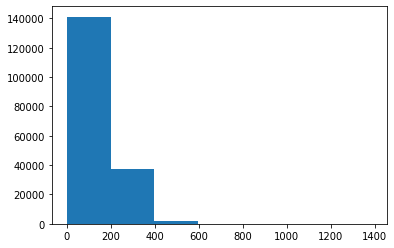

In [ ]:
import matplotlib.pyplot as plt

plt.hist(chars_len, bins=7);

In [ ]:
output_seq_char_len = int(np.percentile(chars_len, 95))
output_seq_char_len

290

In [ ]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')

char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print('Numbers of differents characters: ', len(char_vocab))
print('Most common characters: ', char_vocab[:5])
print('Least common characters: ', char_vocab[-5:])

Numbers of differents characters:  28
Most common characters:  ['', '[UNK]', 'e', 't', 'i']
Least common characters:  ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_chars = random.choice(train_chars)
print('Charified text: ', random_chars)
print('\nLength chars: ', len(random_chars.split()))
print('\nVectorized chars: ', char_vectorizer(random_chars))

Charified text:  i n   t h e   a t   g r o u p   ,   t h e   t h r e e   t e a r   p r o t e i n s   c o n t i n u e d   t o   d e c r e a s e   i n   b o t h   t h e   a n a l y s e s   .

Length chars:  70

Vectorized chars:  tf.Tensor(
[ 4  6  3 13  2  5  3 18  8  7 16 14  3 13  2  3 13  8  2  2  3  2  5  8
 14  8  7  3  2  4  6  9 11  7  6  3  4  6 16  2 10  3  7 10  2 11  8  2
  5  9  2  4  6 22  7  3 13  3 13  2  5  6  5 12 19  9  2  9  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

In [ ]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name='char_embed')

print('Charified text: ', random_chars)
print('\nVectorized chars: ', char_vectorizer(random_chars))
print('\nEmbed chars: ', char_embed(char_vectorizer(random_chars)))

Charified text:  i n   t h e   a t   g r o u p   ,   t h e   t h r e e   t e a r   p r o t e i n s   c o n t i n u e d   t o   d e c r e a s e   i n   b o t h   t h e   a n a l y s e s   .

Vectorized chars:  tf.Tensor(
[ 4  6  3 13  2  5  3 18  8  7 16 14  3 13  2  3 13  8  2  2  3  2  5  8
 14  8  7  3  2  4  6  9 11  7  6  3  4  6 16  2 10  3  7 10  2 11  8  2
  5  9  2  4  6 22  7  3 13  3 13  2  5  6  5 12 19  9  2  9  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorized = char_vectorizer(inputs)
char_embeds = char_embed(char_vectorized)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(char_embeds)
x = layers.GlobalAveragePooling1D()(x)
#x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_8 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_8   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 5)                 325

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=10,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/10
562/562 [==============================] - 6s 9ms/step - loss: 1.4605 - accuracy: 0.3479 - val_loss: 1.4891 - val_accuracy: 0.3298
Epoch 2/10
562/562 [==============================] - 5s 9ms/step - loss: 1.3699 - accuracy: 0.4196 - val_loss: 1.4808 - val_accuracy: 0.3225
Epoch 3/10
562/562 [==============================] - 5s 9ms/step - loss: 1.3269 - accuracy: 0.4518 - val_loss: 1.4864 - val_accuracy: 0.3291
Epoch 4/10
562/562 [==============================] - 5s 9ms/step - loss: 1.3003 - accuracy: 0.4591 - val_loss: 1.4872 - val_accuracy: 0.3577
Epoch 5/10
562/562 [==============================] - 5s 8ms/step - loss: 1.2934 - accuracy: 0.4593 - val_loss: 1.4817 - val_accuracy: 0.3634
Epoch 6/10
562/562 [==============================] - 5s 9ms/step - loss: 1.2869 - accuracy: 0.4669 - val_loss: 1.4806 - val_accuracy: 0.3574
Epoch 7/10
562/562 [==============================] - 3s 5ms/step - loss: 1.2796 - accuracy: 0.4654 - val_loss: 1.4815 - val_accuracy: 0.3404
Epoch 

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 1.2353 - accuracy: 0.4960


[1.2352588176727295, 0.49596187472343445]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 49.596186945584535,
 'f1': 0.454423579527234,
 'precision': 0.45391055822542137,
 'recall': 0.49596186945584536}

### Model 4: Combining pretrained token embeddings + character embeddings

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

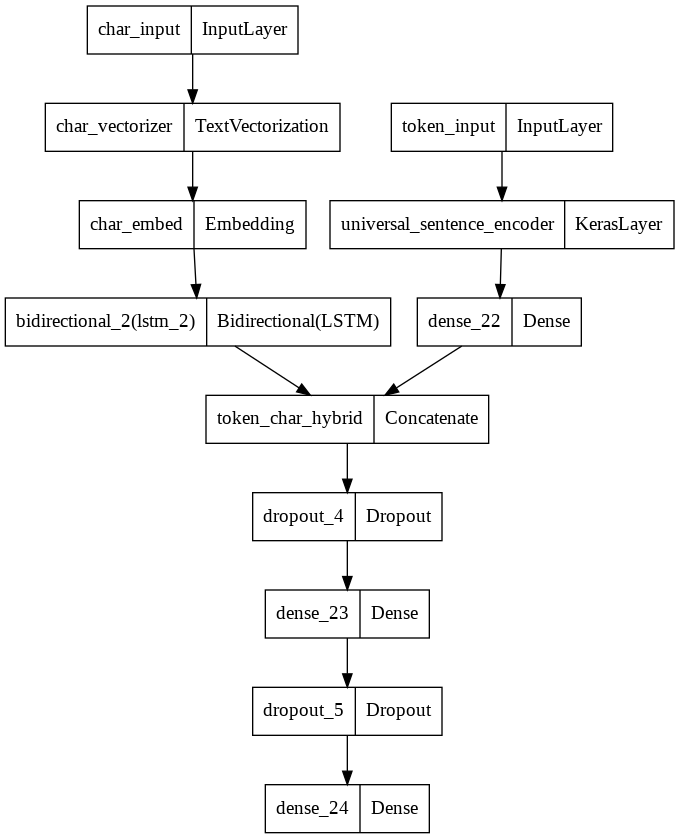

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_4)

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset, 
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 32s 50ms/step - loss: 0.9730 - accuracy: 0.6135 - val_loss: 0.7894 - val_accuracy: 0.6928
Epoch 2/10
562/562 [==============================] - 19s 33ms/step - loss: 0.7981 - accuracy: 0.6914 - val_loss: 0.7256 - val_accuracy: 0.7211
Epoch 3/10
562/562 [==============================] - 19s 33ms/step - loss: 0.7725 - accuracy: 0.7042 - val_loss: 0.6955 - val_accuracy: 0.7390
Epoch 4/10
562/562 [==============================] - 19s 35ms/step - loss: 0.7462 - accuracy: 0.7160 - val_loss: 0.6694 - val_accuracy: 0.7450
Epoch 5/10
562/562 [==============================] - 19s 34ms/step - loss: 0.7476 - accuracy: 0.7160 - val_loss: 0.6606 - val_accuracy: 0.7473
Epoch 6/10
562/562 [==============================] - 29s 52ms/step - loss: 0.7419 - accuracy: 0.7176 - val_loss: 0.6471 - val_accuracy: 0.7600
Epoch 7/10
562/562 [==============================] - 31s 55ms/step - loss: 0.7109 - accuracy: 0.7303 - val_loss: 0.6428 - val_accuracy:

In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 35s 37ms/step - loss: 0.6240 - accuracy: 0.7628


[0.6239616870880127, 0.76284259557724]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 76.28425791076393,
 'f1': 0.759025747937249,
 'precision': 0.7616676724234396,
 'recall': 0.7628425791076393}

### Model 5: Transfer Learning with token embeddings + char embeddings + positional embeddings

In [ ]:
train_df['line_number'].values_counts()

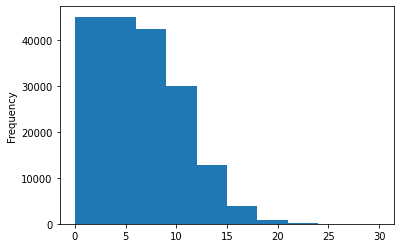

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

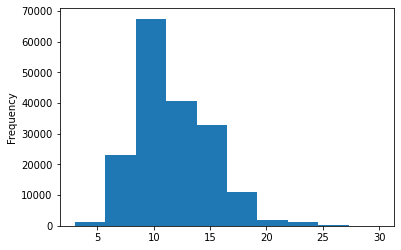

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [ ]:
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeds = char_embed(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(32))(char_embeds)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

line_numbers_input = layers.Input(shape=(15,), dtype=tf.int32, name='line_numbers_input')
x = layers.Dense(32, activation='relu')(line_numbers_input)
line_number_model = tf.keras.Model(inputs=line_numbers_input,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_line_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

combined_embeddings = layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

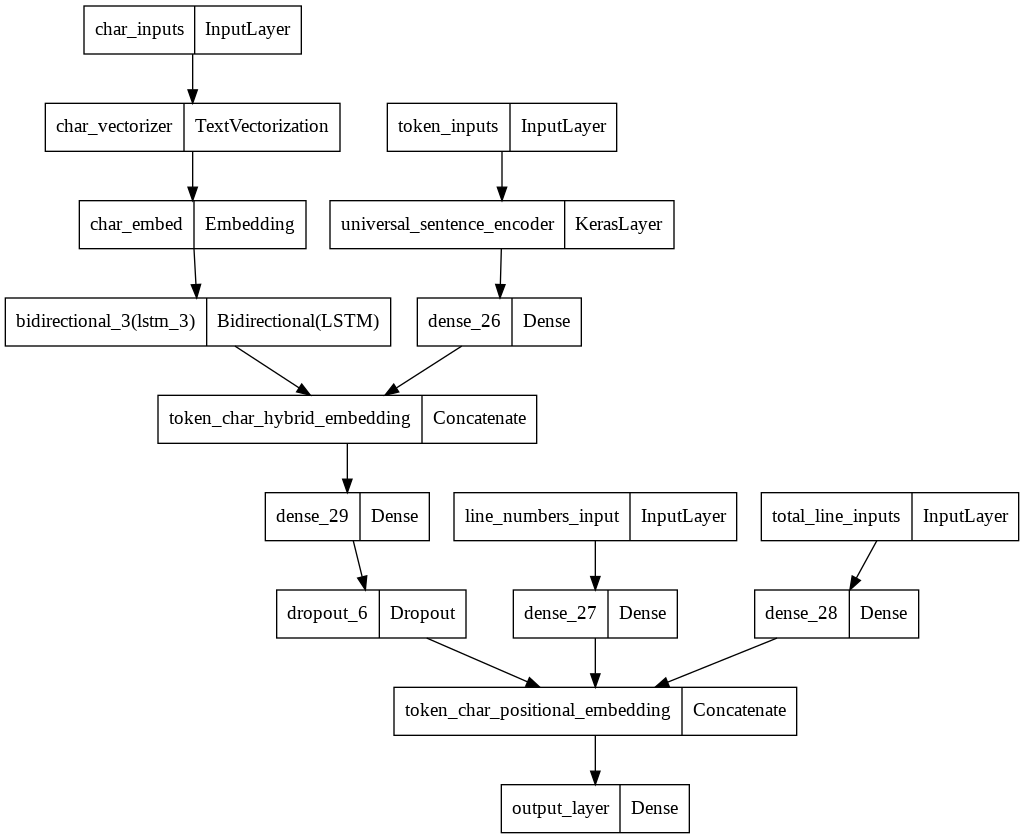

In [ ]:
plot_model(model_5)

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f25b24b9dd0> True
<keras.engine.input_layer.InputLayer object at 0x7f25b2461f10> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f25b108bb50> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f269ec6d690> False
<keras.layers.embeddings.Embedding object at 0x7f25b10ad390> True
<keras.layers.core.dense.Dense object at 0x7f25b2461fd0> True
<keras.layers.wrappers.Bidirectional object at 0x7f25b2439510> True
<keras.layers.merge.Concatenate object at 0x7f25b2e2e510> True
<keras.engine.input_layer.InputLayer object at 0x7f25b23c1290> True
<keras.engine.input_layer.InputLayer object at 0x7f25b247e610> True
<keras.layers.core.dense.Dense object at 0x7f25b23cd0d0> True
<keras.layers.core.dense.Dense object at 0x7f25b23b4910> True
<keras.layers.core.dense.Dense object at 0x7f25b243de90> True
<keras.layers.core.dropout.Dropout object at 0x7f25b2374190> True
<keras.layers.merge.Concatenate object at 0x7f25b2

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot, 
                                                                train_sentences,
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 36ms/step - loss: 1.0945 - accuracy: 0.7257 - val_loss: 0.9808 - val_accuracy: 0.8082
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9658 - accuracy: 0.8157 - val_loss: 0.9477 - val_accuracy: 0.8295
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9498 - accuracy: 0.8237 - val_loss: 0.9410 - val_accuracy: 0.8281


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.19541903879252,
 'f1': 0.8310012090563061,
 'precision': 0.8309887979607294,
 'recall': 0.8319541903879253}

## Compare model results

In [ ]:
all_model_results = pd.DataFrame({'baseline':baseline_results,
                                  'custom_token_embed_conv1d': model_1_results,
                                  'pretrained_token_embed': model_2_results,
                                  'custom_char_embed_conv1d': model_3_results,
                                  'hybrid_char_token_embed': model_4_results,
                                  'tribrid_pos_char_token_embed': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.442341,0.780811,0.784423,0.781696
pretrained_token_embed,73.970608,0.742555,0.739706,0.740458
custom_char_embed_conv1d,49.596187,0.453911,0.495962,0.454424
hybrid_char_token_embed,76.284258,0.761668,0.762843,0.759026
tribrid_pos_char_token_embed,83.195419,0.830989,0.831954,0.831001


In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

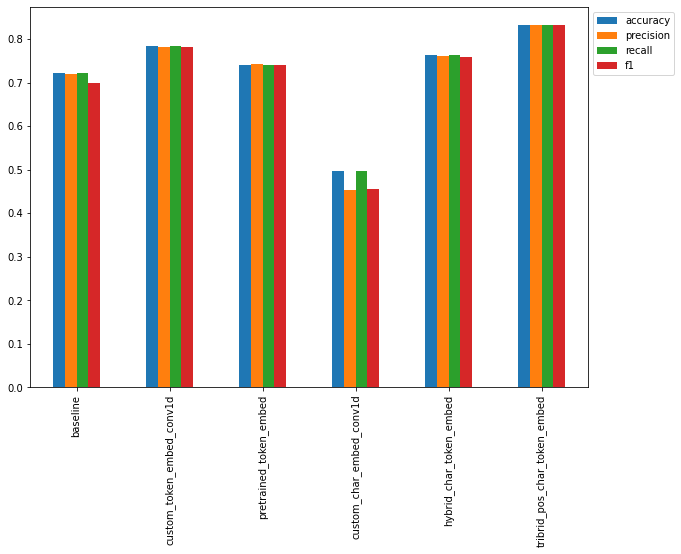

In [ ]:
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

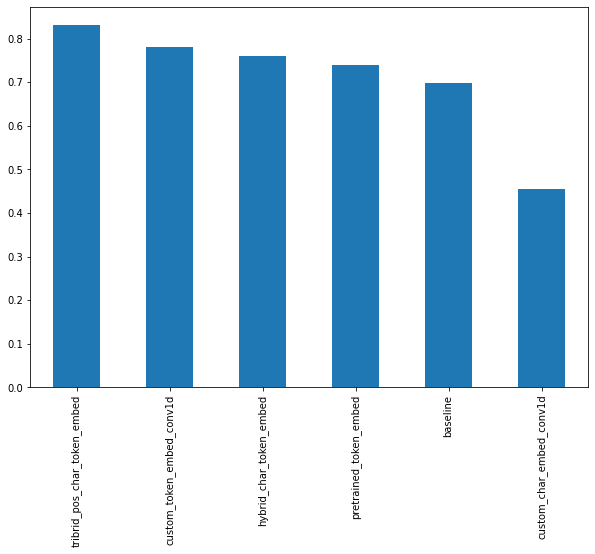

In [ ]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7));

## Save and load best model

In [ ]:
model_5.save('skimlit_tribrid_model')

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [ ]:
loaded_model_pred_probs = loaded_model.predict(val_pos_char_token_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)

loaded_model_results = calculate_results(val_labels_encoded, loaded_model_preds)
loaded_model_results

{'accuracy': 83.19541903879252,
 'f1': 0.8310012090563061,
 'precision': 0.8309887979607294,
 'recall': 0.8319541903879253}

In [ ]:
model_5_results

{'accuracy': 83.19541903879252,
 'f1': 0.8310012090563061,
 'precision': 0.8309887979607294,
 'recall': 0.8319541903879253}

## Evaluate model on test dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)

test_results = calculate_results(test_labels_encoded, test_preds)
test_results

{'accuracy': 82.86377965820475,
 'f1': 0.8276216395750322,
 'precision': 0.8275027334135786,
 'recall': 0.8286377965820475}